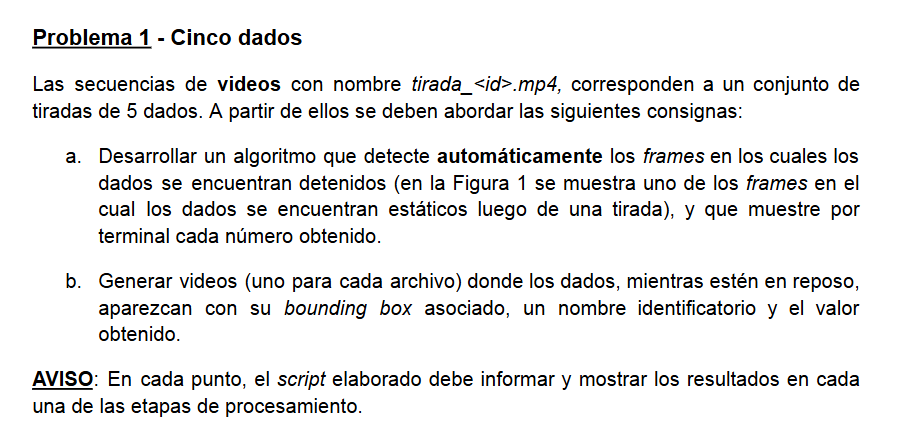

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [77]:
archivo = 'src/tirada_1.mp4' 
archivo_salida = 'resultado_tirada.mp4'

In [78]:
os.makedirs("frames", exist_ok = True) 

In [79]:
#lectura
cap = cv2.VideoCapture(archivo)  
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  
fps = int(cap.get(cv2.CAP_PROP_FPS)) 
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 

print(width)
print(height)
print(fps)
print(n_frames)

1080
2224
30
146


In [80]:
frame_prev = None 
cont_fram_est = 0
cont_frame_global = 0
umbral_mov = 2.5
frame_estaticos = 0

In [81]:
#analiza si hay imagen quieta y guarda el frame estatico
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)

    #detectar movimiento
    es_estatico = False
    if frame_prev is not None:
        frame_diff = cv2.absdiff(frame_prev, blur)   #calcular diferencia entre frames
        motion_score = np.mean(frame_diff)
        
        if motion_score < umbral_mov:
            frames_estaticos += 1
        else:
            frames_estaticos = 0 

        if frames_estaticos > 25:    # quieto 25 frames seguidos
            es_estatico = True
            nombre_archivo = f"frames/frame_{cont_frame_global}.jpg" #guardar frame quieto
            cv2.imwrite(nombre_archivo, frame)
            cont_frame_global += 1

    frame_prev = blur

print(cont_frame_global)

cap.release()
cv2.destroyAllWindows() 

6


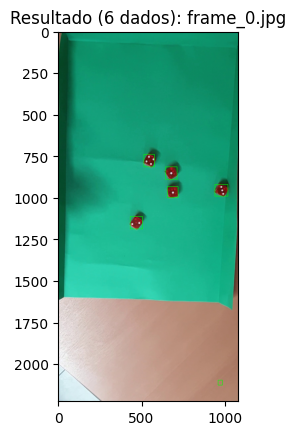

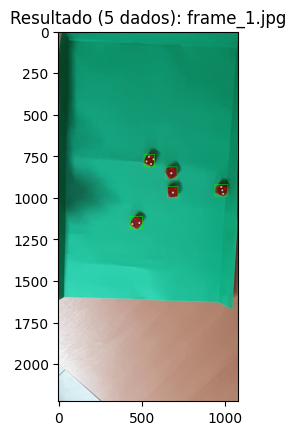

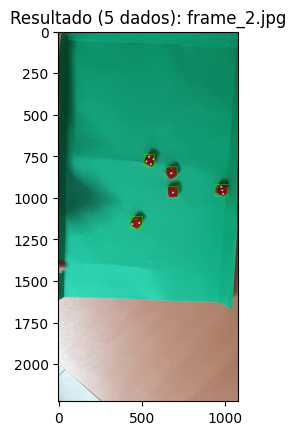

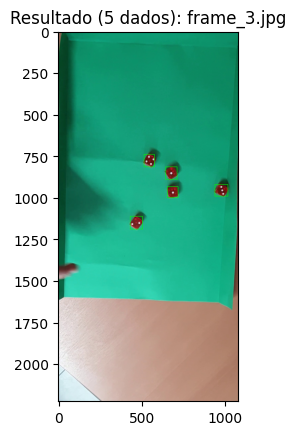

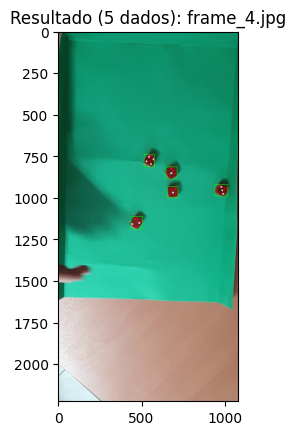

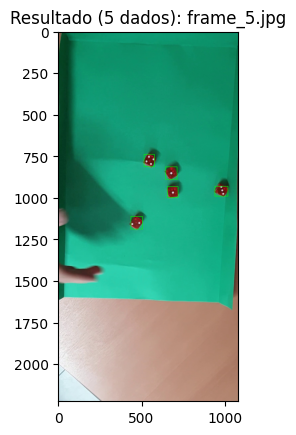

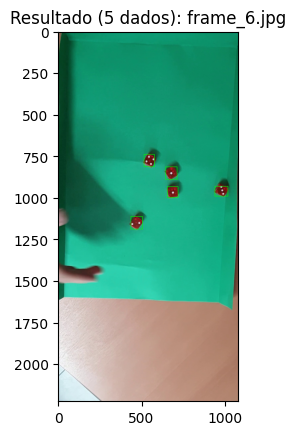

In [ ]:

carpeta_frames = "frames"
AREA_MINIMA = 500  
AREA_MAXIMA = 30000

rojo_bajo_1 = np.array([0, 100, 100])
rojo_alto_1 = np.array([10, 255, 255])

rojo_bajo_2 = np.array([170, 100, 100])
rojo_alto_2 = np.array([180, 255, 255])

lista_archivos = os.listdir(carpeta_frames)

for nombre_archivo in lista_archivos:
    if nombre_archivo.endswith('.jpg'):
        ruta_completa = os.path.join(carpeta_frames, nombre_archivo)
        imagen = cv2.imread(ruta_completa)

        imagen_dibujo = imagen.copy()       
        """imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        _, imagen_binaria = cv2.threshold(imagen_gris, 70, 255, cv2.THRESH_BINARY_INV)"""
        
        hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
        mask1 = cv2.inRange(hsv, rojo_bajo_1, rojo_alto_1)
        mask2 = cv2.inRange(hsv, rojo_bajo_2, rojo_alto_2)
        imagen_binaria = mask1 + mask2
        
        kernel = np.ones((7, 7), np.uint8)
        imagen_binaria = cv2.morphologyEx(imagen_binaria, cv2.MORPH_CLOSE, kernel)
        imagen_binaria = cv2.morphologyEx(imagen_binaria, cv2.MORPH_OPEN, kernel)
        contours, hierarchy = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        dados_encontrados = 0

        for cnt in contours:
            area = cv2.contourArea(cnt)

            if area > AREA_MINIMA and area < AREA_MAXIMA:

                x,y,w,h = cv2.boundingRect(cnt)

                aspect_ratio = w / h
                if 0.5 < aspect_ratio < 1.5:
                    #cv2.drawContours(imagen_dibujo, [cnt], contourIdx=-1, color=(255, 0, 0), thickness=2)
                    cv2.rectangle(imagen_dibujo, (x,y), (x+w,y+h), color=(0, 255, 0), thickness=2)
                    dados_encontrados += 1
        
        if len(contours) > 0:   
            plt.figure()
            plt.title(f"Resultado ({dados_encontrados} dados): {nombre_archivo}")
            plt.imshow(cv2.cvtColor(imagen_dibujo, cv2.COLOR_BGR2RGB))
            plt.show(block=False) 
        else:
            print(f"No se encontraron dados en {nombre_archivo} con los parámetros actuales.")
    else:
        print(f"Error al cargar la imagen: {nombre_archivo}")

cv2.destroyAllWindows()
cap.release()
